In [2]:
import torch
import numpy as np
import math
import argparse
from augerino import datasets, models, losses
import glob
import re
import pandas as pd
import sys
sys.path.append("../learning-invariance/")
from data.generate_data import *
from loss_getters import compute_loss
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [5]:
softplus = torch.nn.Softplus()
savedir = "./saved-outputs/"

epochs = 20
reg = 0.05
## stanard running procedure ##
net = models.SimpleConv(c=32, num_classes=4)
augerino = models.UniformAug()
model = models.AugAveragedModel(net, augerino,ncopies=1)

ntrain = 10000
ntest = 5000

trainloader, testloader = generate_mario_data(ntrain=ntrain, ntest=ntest,
                                              batch_size=128, dpath="/home/sp2058/augerino/experiments/mario-iggy/data/")

/home/sp2058/miniconda3/envs/augerino/lib/python3.11/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/sp2058/miniconda3/envs/augerino/lib/python3.11/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/sp2058/augerino/experiments/mario-iggy/data/generate_data.py:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)


In [6]:
start_widths = torch.ones(6) * -5.

model.aug.set_width(start_widths)

In [7]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01,
                            weight_decay=1e-3)
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

logged_aug = []

criterion = losses.unif_aug_loss

In [8]:
count = 0
for epoch in range(epochs):  # loop over the dataset multiple times
    for i, data in enumerate(trainloader):
        count += 1
        if count < 100:
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # print(inputs.shape)
            outputs = model(inputs)
            loss = criterion(outputs, labels, model,
                            reg=reg)
            loss.backward()
            optimizer.step()

            log = softplus(model.aug.width).tolist()
            log += model.aug.width.grad.data.tolist()
            log += [loss.item(), count]
            logged_aug.append(log)
    print("epoch ", epoch)

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19


## Now Compute the Gradients

In [9]:
logger = pd.DataFrame(logged_aug)
cols = ['width' + str(i) for i in range(6)]
cols += ['grad' + str(i) for i in range(6)]
cols += ['loss', 'iter']
logger.columns = cols
logger = logger.reset_index()

In [10]:
x, y = next(iter(trainloader))
x = x.cuda()
y = y.cuda()

In [11]:
train_widths = model.aug.width.data.clone()
widths = torch.linspace(-5, 5, 20)
grads = torch.zeros_like(widths)

In [12]:
grad_logger = []
for batch_idx, batch in enumerate(trainloader):
    if batch_idx < 25:
        x, y = batch
        x, y = x.cuda(), y.cuda()
        for idx, ww in enumerate(widths):
            optimizer.zero_grad()
            temp_widths = train_widths.clone()
            temp_widths[2] = ww
            model.aug.set_width(temp_widths.cuda())
            preds = model(x)

            acc = torch.sum(torch.argmax(preds, -1) == y)

        #     loss = loss_func(convnet.model(x), y, convnet.model, reg=0.1)
            loss = criterion(model(x), y, model,
                                reg=reg)

            loss.backward()

            grad_logger.append([batch_idx, ww.item(), model.aug.width.grad[2].item(), acc.item()])

In [13]:
log = pd.DataFrame(grad_logger)
log.columns = ['idx', 'width', 'grad', 'acc']

log['sp_width'] = softplus(torch.tensor(log['width']))
log['acc'] = log['acc']/128.

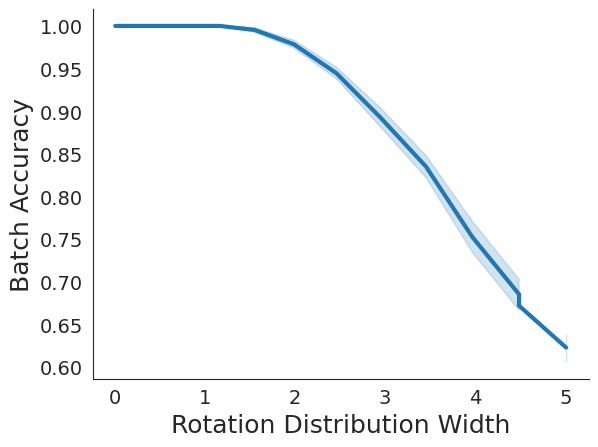

In [14]:
sns.set_style("white")
lwd=3.
fs=18
sns.lineplot(x='sp_width', y='acc', data=log,
            linewidth=lwd)
plt.xlabel("Rotation Distribution Width", fontsize=fs)
plt.ylabel("Batch Accuracy", fontsize=fs)
sns.despine()
plt.tick_params("both", labelsize=fs-4)
plt.show()

/tmp/ipykernel_2721072/977730012.py:12: MatplotlibDeprecationWarning: The InsetPosition class was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use Axes.inset_axes instead.
  ip = InsetPosition(ax, [0.08,0.45,0.5,0.5])


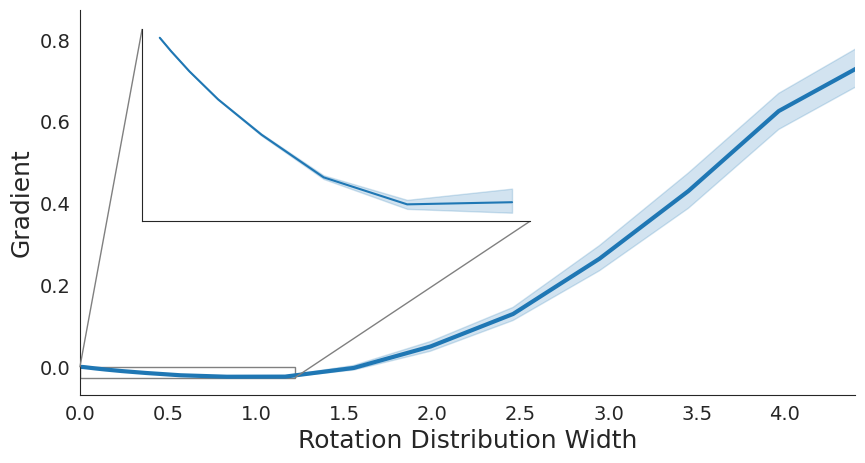

In [15]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)

sns.set_style("white")
sns.lineplot(x='sp_width', y='grad', data=log,
            linewidth=lwd, ax=ax)
ax.set_xlabel("Rotation Distribution Width", fontsize=fs)
ax.set_ylabel("Gradient", fontsize=fs)
ax.tick_params("both", labelsize=fs-4)
sns.despine()

ax2 = plt.axes([0.2,0.2, 0.01,0.01])
ip = InsetPosition(ax, [0.08,0.45,0.5,0.5])
ax2.set_axes_locator(ip)
mark_inset(ax, ax2, loc1=2, loc2=4, fc="none", ec='0.5')
sns.lineplot(x='sp_width', y='grad', data=log[(log['sp_width']< 1.2) & (log['sp_width'] >0.05)])
sns.despine()
# ax2.axhline(0)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("")
ax2.set_ylabel("")
ax.set_xlim(0, 4.4)
plt.savefig("./grad_example.png", bbox_inches='tight')
plt.show()